In [ ]:
# TODO: Fix both underfitting (loss value not low enough) and overfitting (Validation Score too high)

In [105]:
import requests
from pathlib import Path
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_path = Path("data/")
train_path = data_path / "train"

if train_path.is_dir():
  print(f"{train_path} directory already exists....skipping download")
else:
  print(f"{train_path} does not exist, creating one....")
  train_path.mkdir(parents = True, exist_ok = True)

with open(train_path / "train.csv", "wb") as f:
  request = requests.get("https://github.com/sriskid/Kaggle/raw/main/black_friday_prediction/train_oSwQCTC/train.csv")
  print("Downloading training data....")
  f.write(request.content)

data/train does not exist, creating one....


In [3]:
train_data = pd.read_csv(train_path / "train.csv")

In [4]:
train_data

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969
...,...,...,...,...,...,...,...,...,...,...,...,...
550063,1006033,P00372445,M,51-55,13,B,1,1,20,NaN,NaN,368
550064,1006035,P00375436,F,26-35,1,C,3,0,20,NaN,NaN,371
550065,1006036,P00375436,F,26-35,15,B,4+,1,20,NaN,NaN,137
550066,1006038,P00375436,F,55+,1,C,2,0,20,NaN,NaN,365


# Exploratory Data Analysis

## Initial Data Visualization

In [5]:
# Check for missign values
train_data.isnull().sum()
# The only missing values combe from product_category_2 and product_category_3

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [7]:
categorical_columns = train_data.select_dtypes(include=object).columns.tolist()
print(len(categorical_columns))

5


In [8]:
categorical_columns

['Product_ID', 'Gender', 'Age', 'City_Category', 'Stay_In_Current_City_Years']

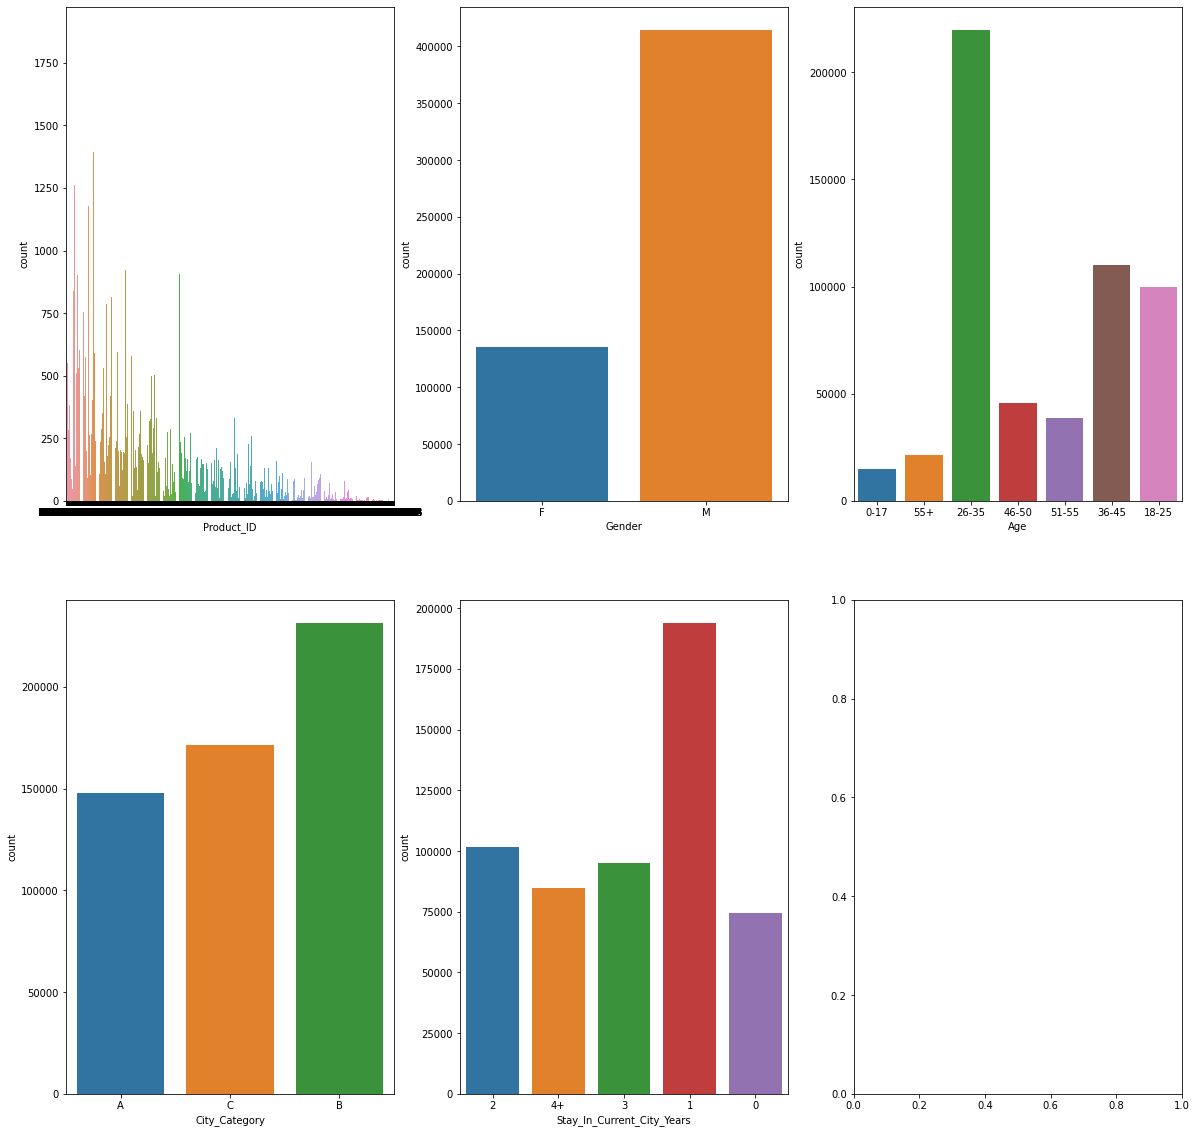

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 20))
for i, column in enumerate(categorical_columns):
  sns.countplot(data = train_data, x = column, ax = axes[i // 3, i % 3])

From this plot we get a few useful pieces of information:


*   There are far more men purchasing items than women, this could be due to a few reasons, namely there are far more products that appeal to men than women, or the products being bought are on behalf of their spouse and therefore the appeal of the item itself may not be for them.

*   A huge number of purchases come from those age 26 - 35, meaning that the majority of products cater to this age range, or that they are buying for others. Furthermore, the age range with the least amount of purchasing are 0 - 17 and 55 +. This could be due to either the products not catering to them or that they are dependent on someone within the 26 - 35 range category to buy 
things for them

*   People from City C made more purchases
*   Poeple who have stayed in their city for a year made the most number of purchases





<AxesSubplot:xlabel='Gender', ylabel='count'>

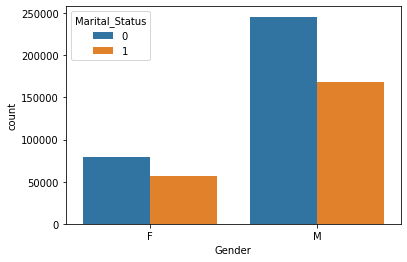

In [10]:
# Check the number of men making purchases based on their marital status
sns.countplot(data = train_data, x = "Gender", hue = "Marital_Status")

From the above plot, we see that men and women make fewer purchases where they are married versus when they are not married. However, regardless of whether married or not, men made more purchases. 

<AxesSubplot:xlabel='Age', ylabel='count'>

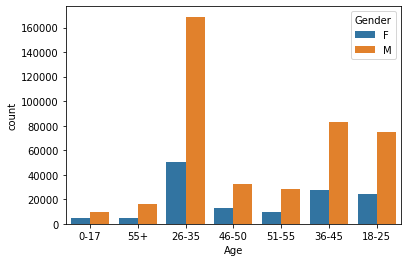

In [11]:
# Then in that case, let us check the age ranges that people are making purchases based on gender
sns.countplot(data = train_data, x = "Age", hue = "Gender")

From this plot, we see that overall men make more purchases than women. In the range of 26 - 35 we see a huge increase in the number of purchases by men. This could be due to buying items for themselves, their spouse, or their children.

<AxesSubplot:xlabel='Age', ylabel='count'>

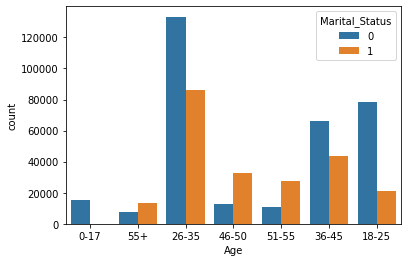

In [12]:
# Check the Age Ranges Based off Marital Status
sns.countplot(data = train_data, x = "Age", hue = "Marital_Status")

Looking at the breakdown of age ranges:


*   Obviously those of age range 0 - 17 are not going to be married
*   For the age range 26 - 35, those who are not married make more purchases
* Across all married age ranges, those who are 26 - 35 make the most number of purchases



<AxesSubplot:xlabel='Age', ylabel='Purchase'>

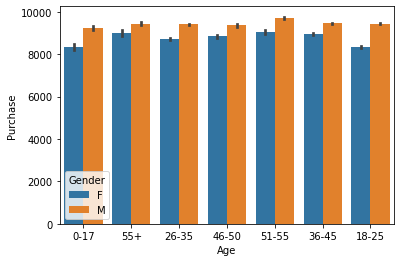

In [13]:
# Break down the ages by gender
sns.barplot(data = train_data, x = "Age", y = "Purchase", hue = "Gender")

The above plot shows that across all age ranges, men are spending the most 

<AxesSubplot:xlabel='Marital_Status', ylabel='Purchase'>

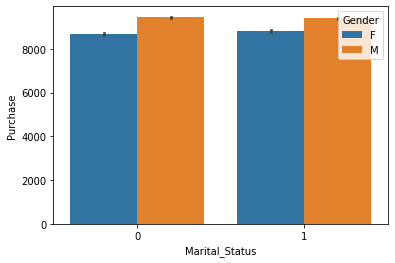

In [14]:
# Plot purchasing based on marital status
sns.barplot(data = train_data, x = "Marital_Status", y = "Purchase", hue = "Gender")

From the above we know that:


*   On average men, spend more whether they are married or not



<AxesSubplot:xlabel='Age', ylabel='Purchase'>

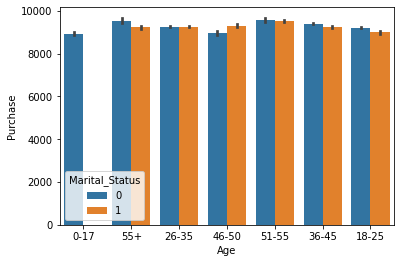

In [15]:
# Plot Purchase Amount Based on Age and discriminate based on Marital Status
sns.barplot(data = train_data, x = "Age", y = "Purchase", hue = "Marital_Status")

Across all age ranges (except for 0 - 17), we see that those who are married or not married spent about the same amount of money on average

<AxesSubplot:xlabel='City_Category', ylabel='Purchase'>

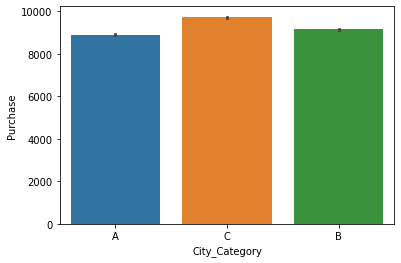

In [16]:
sns.barplot(data = train_data, x = "City_Category", y = "Purchase")

The above plot shows that people from City C spent the most

<AxesSubplot:xlabel='City_Category', ylabel='Purchase'>

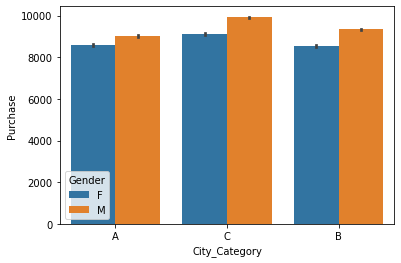

In [17]:
# Plot the purchase amount by city dividing by gender
sns.barplot(data = train_data, x = "City_Category", y = "Purchase", hue = "Gender")

If we break down the cities by gender, we see that specifically men from City C spent the most and that among all 3 cities, men spent the most.

<AxesSubplot:xlabel='Gender', ylabel='Purchase'>

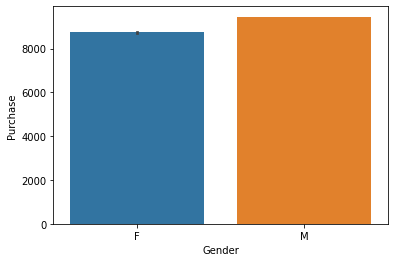

In [18]:
sns.barplot(data = train_data, x = "Gender", y = "Purchase")

As has been the case with the other plots, on average men spend more than women

<AxesSubplot:xlabel='Gender', ylabel='Purchase'>

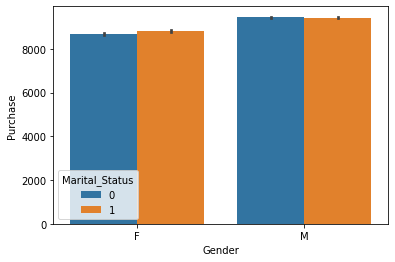

In [19]:
sns.barplot(data = train_data, x = "Gender", y = "Purchase", hue = "Marital_Status")

If we look at marital status, men and women spent roughly the same amount regardless of marital status, with men spending on average more. 

### Exploring Occupation

<AxesSubplot:xlabel='Occupation', ylabel='count'>

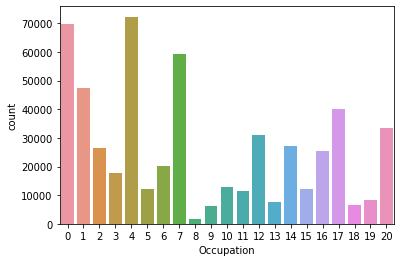

In [20]:
# Plot counts of the different occupations to see which occupation has the highest count
sns.countplot(x  = train_data["Occupation"])

From the above plot we see that those in occupation 0 and 4 appear the most in the data followed by those in occupation 3

<AxesSubplot:xlabel='Occupation', ylabel='count'>

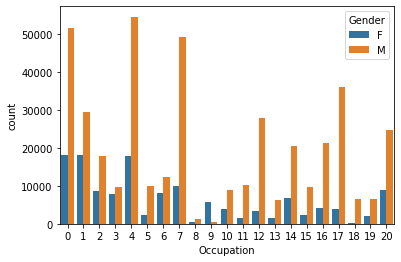

In [21]:
# Plot count of occupation based on gender
sns.countplot(x  = train_data["Occupation"], hue = train_data["Gender"])

Across almost all occupations, there are more men than women except for occupation 9.

<AxesSubplot:xlabel='Occupation', ylabel='Purchase'>

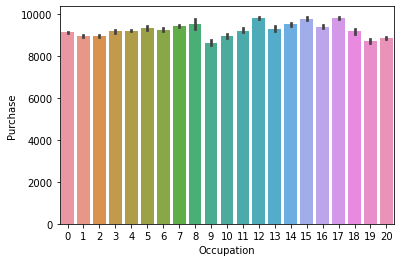

In [22]:
# Plot occupation to purchase amount
sns.barplot(data = train_data, x = "Occupation", y = "Purchase")

Overall across all occupations, the average purchase amount is relatively the same

<AxesSubplot:xlabel='Occupation', ylabel='Purchase'>

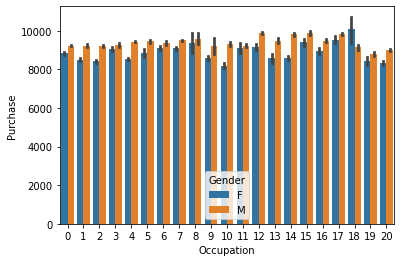

In [23]:
# What if we discriminated the occupations based on gender
sns.barplot(data = train_data, x = "Occupation", y = "Purchase", hue = "Gender")

Across almost all occupations, men on average purchased more than women, however in occupation 18, we see that women spent far more than men. Furthermore, we see that the difference between men and women in spending across the different occupations is not that much compared to the large discrepancy between the number of men and women across the occupations (Occupation 18 has far more men than women and Occupation 9 has far more women than men, however men still had on average higher purchases).

 ## Cleaning up the Data

Looking at the User_ID, of the data, we see that in some instances the same User_ID is making purchases, meaning that the customer is buying multiple items. We can filter the data to condense the unique User_IDs. 

In [24]:
# Create a DataFrame of only the unique User_ID
first_unique = train_data[train_data["User_ID"] == train_data["User_ID"].unique()[0]]
all_unique = first_unique.head(1)
all_unique["Purchase_Count"] = list(first_unique.User_ID.value_counts())

for ID in train_data["User_ID"].unique()[1:]:
  unique_id = train_data[train_data["User_ID"] == ID].head(1)
  count = list(train_data[train_data["User_ID"] == ID].User_ID.value_counts())
  unique_id["Purchase_Count"] = count
  all_unique = pd.concat([all_unique, unique_id]).reset_index(drop=True)
all_unique.drop(["Product_ID", "Product_Category_1", "Product_Category_2", "Product_Category_3", "Purchase"], axis=1, inplace=True)

<ipython-input-24-35a42c283480>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_unique["Purchase_Count"] = list(first_unique.User_ID.value_counts())


In [25]:
all_unique.head()

,User_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Purchase_Count
0,1000001,F,0-17,10,A,2,0,35
1,1000002,M,55+,16,C,4+,0,77
2,1000003,M,26-35,15,A,3,0,29
3,1000004,M,46-50,7,B,2,1,14
4,1000005,M,26-35,20,A,1,1,106


### Exploratory Data Analysis on the Unique IDs

<AxesSubplot:xlabel='Gender', ylabel='count'>

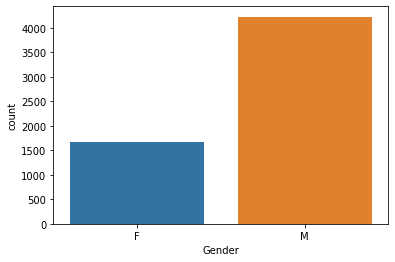

In [26]:
sns.countplot(data = all_unique, x = "Gender")

Among all Unique IDs, men make more purchases than women

<AxesSubplot:xlabel='Age', ylabel='count'>

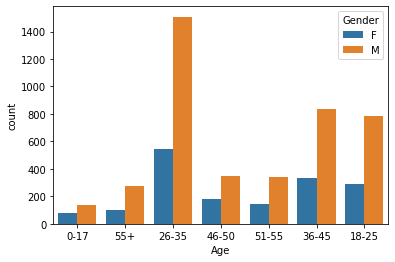

In [27]:
sns.countplot(data = all_unique, x = "Age", hue = "Gender")

We see the same trend as previously in that men of age range 26 - 35 make the most number of purchases

<AxesSubplot:xlabel='Age', ylabel='count'>

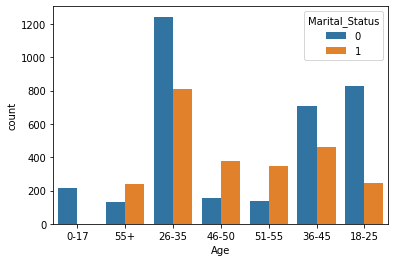

In [28]:
sns.countplot(data = all_unique, x = "Age", hue = "Marital_Status")

Those who are unmarried in the age range 26 - 35 make the most number of purchases

<AxesSubplot:xlabel='City_Category', ylabel='count'>

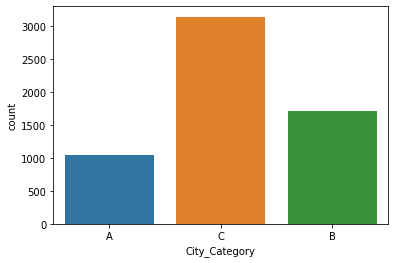

In [29]:
sns.countplot(data = all_unique, x = "City_Category")

As seen previously, those from City C make the most number of purchases

<AxesSubplot:xlabel='Occupation', ylabel='count'>

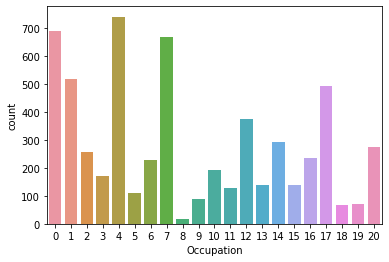

In [30]:
sns.countplot(data = all_unique, x = "Occupation")

As observed prior, those in occupation 0, 4, and 7 make the most number of purchases

## Observing the Top 10 Purchases

In [31]:
top_ten = all_unique.sort_values(by="Purchase_Count", ascending=False).head(10)
top_ten

,User_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Purchase_Count
1488,1001680,M,26-35,20,A,3,1,1026
3772,1004277,M,36-45,16,A,0,0,979
1716,1001941,M,36-45,17,A,1,0,898
1049,1001181,M,36-45,7,A,3,1,862
790,1000889,M,46-50,20,A,1,0,823
3179,1003618,M,55+,17,A,4+,1,767
1022,1001150,F,26-35,20,A,1,0,752
899,1001015,M,36-45,3,A,4+,1,740
5111,1005795,M,26-35,1,A,1,1,729
5141,1005831,M,26-35,1,A,2,1,727


### Exploratory Data Analysis on Top 10 Purchases comparison to Unique IDs

Text(0.5, 1.0, 'Top 10 Purchases')

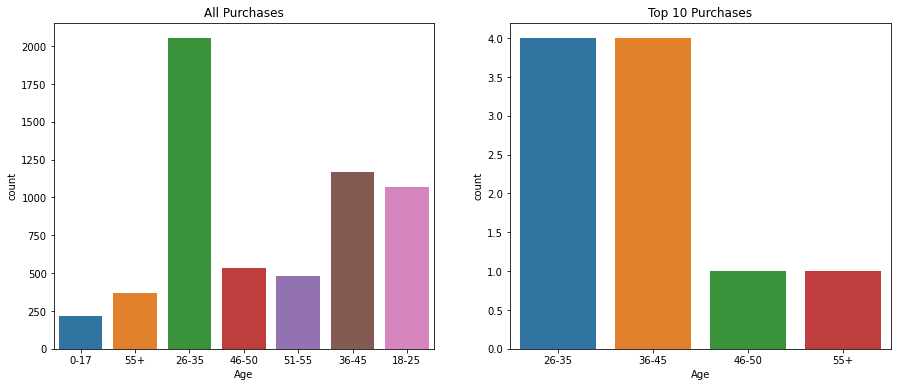

In [32]:
# Plot the age ranges of the top purchases
plt.figure(figsize = (15,6))

plt.subplot(1,2,1)
sns.countplot(data = all_unique, x = "Age")
plt.title("All Purchases")

plt.subplot(1,2,2)
sns.countplot(data = top_ten, x = "Age")
plt.title("Top 10 Purchases")

As we see that unlike prior plots, we see that those of age range 26 - 35 and 36 - 45 make the most number of high purchases, which is different from when looking at all purchases

Text(0.5, 1.0, 'Top Ten Purchases')

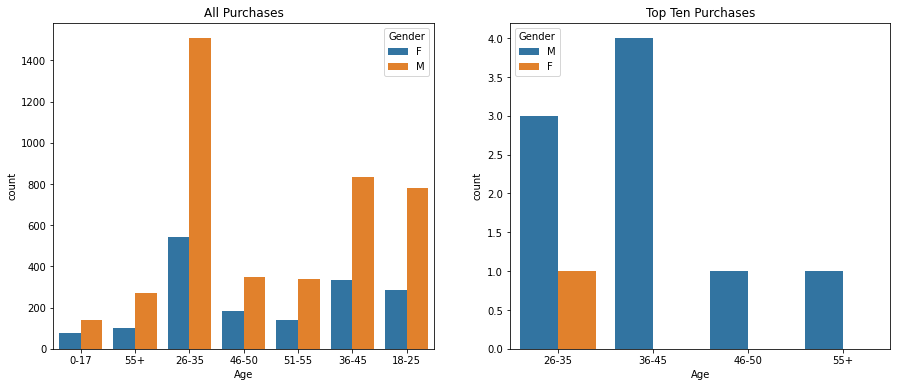

In [33]:
# Break down the previous plot by subdividing by gender
plt.figure(figsize = (15,6))

plt.subplot(1,2,1)
sns.countplot(data = all_unique, x = "Age", hue = "Gender")
plt.title("All Purchases")

plt.subplot(1,2,2)
sns.countplot(data = top_ten, x = "Age", hue = "Gender")
plt.title("Top Ten Purchases")

From the plot, only one women (in the age range 26 - 35) makes any high purchase. However, we see that men in the 36 - 45 age category make very high purchases, whereas those in the 26 - 35 age range make the most overall number of purchases

Text(0.5, 1.0, 'Top Ten Purchases')

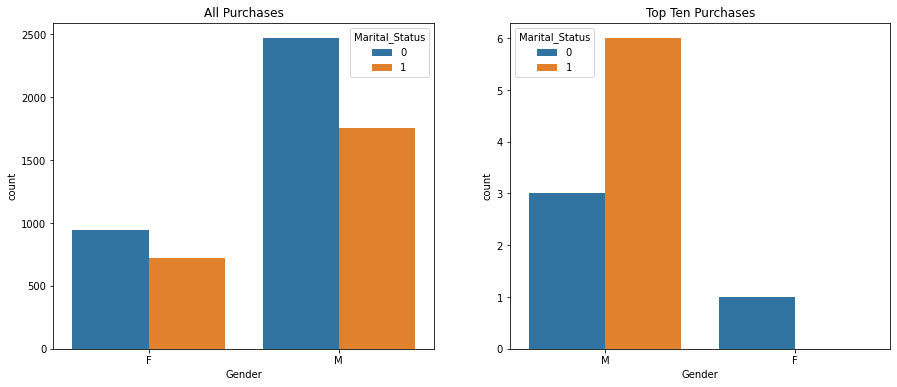

In [34]:
# Break down top purchases by gender differentiating with Marital Status
plt.figure(figsize = (15,6))

plt.subplot(1,2,1)
sns.countplot(data = all_unique, x = "Gender", hue = "Marital_Status")
plt.title("All Purchases")

plt.subplot(1,2,2)
sns.countplot(data = top_ten, x = "Gender", hue = "Marital_Status")
plt.title("Top Ten Purchases")

In this plot, we see a big difference when looking at total number of purchases versus the top ten purchases.
* When looking at all purchases, we see that unmarried men make the most number of purchases, however more married men make high purchases
* Furthermore, we see that only one woman (unmarried) made a high purchase
* This could possibly show that married men make large purchases for family

Text(0.5, 1.0, 'Top Ten Purchases')

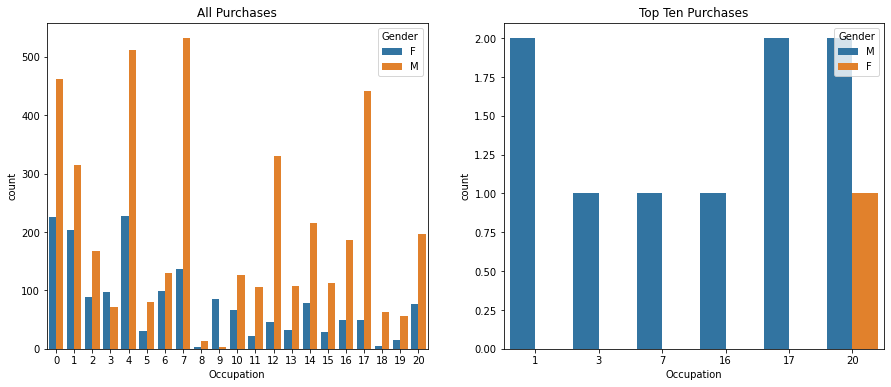

In [35]:
# Break down the top purchases based on Occupation
plt.figure(figsize = (15,6))

plt.subplot(1,2,1)
sns.countplot(data = all_unique, x = "Occupation", hue = "Gender")
plt.title("All Purchases")

plt.subplot(1,2,2)
sns.countplot(data = top_ten, x = "Occupation", hue = "Gender")
plt.title("Top Ten Purchases")

We see that even though occupation 7 has the highest overall number of purchases, occupation 20 makes the highest purchases

Text(0.5, 1.0, 'Top 10 Purchases')

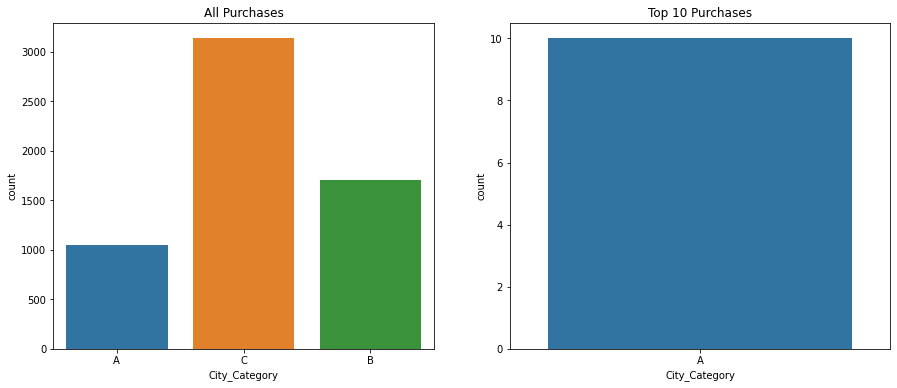

In [36]:
# See which cities make the most and highest purchases
plt.figure(figsize = (15,6))

plt.subplot(1,2,1)
sns.countplot(data = all_unique, x = "City_Category")
plt.title("All Purchases")

plt.subplot(1,2,2)
sns.countplot(data = top_ten, x = "City_Category")
plt.title("Top 10 Purchases")

While City C had the most number of overall purchases, those in City A made all of the top ten purchases. This could be because people in City A are much wealthier. It could also be that the most expensive purchases appeal to those in City A

Text(0.5, 1.0, 'Top 10 Purchases')

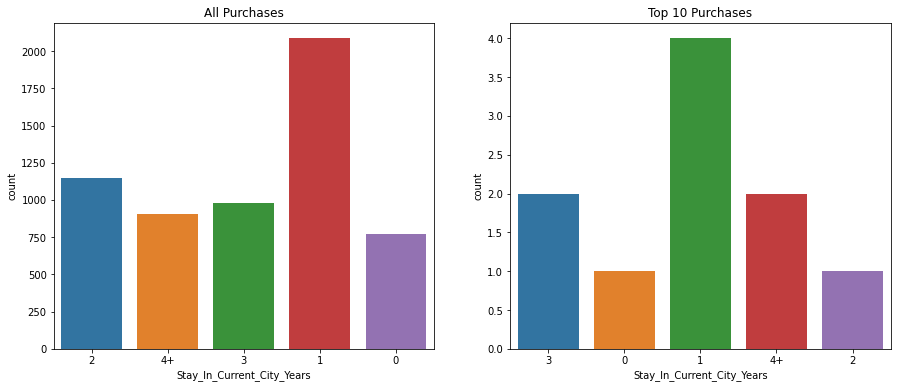

In [37]:
# Break down duration of time in City
plt.figure(figsize = (15,6))

plt.subplot(1,2,1)
sns.countplot(data = all_unique, x = "Stay_In_Current_City_Years")
plt.title("All Purchases")

plt.subplot(1,2,2)
sns.countplot(data = top_ten, x = "Stay_In_Current_City_Years")
plt.title("Top 10 Purchases")

There appears to be no different between overall number of purchases and highest purchases. Those who have stayed in their City for 1 year make the most purchases

## Data Processing

In [38]:
# Fill in the missing values for Product Category 2 and Product Category 3
train_data["Product_Category_2"].fillna(0,inplace=True)
train_data["Product_Category_3"].fillna(0,inplace=True)

I am filling the missing values with zero as since some of the products can belong to multiple categories, I will assume that those with NaN simply means that those products do not belong to those categories

In [39]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

# Drop Product_ID and User_ID
train = train_data.drop(["User_ID","Product_ID"] , axis = 1)

# Gather all of the categorical columns to encode
categorical_columns = train.select_dtypes(include=object).columns.tolist()

# Apply the LabelEncoder to all of the categorical columns
train[categorical_columns] = train[categorical_columns].apply(encoder.fit_transform)

<AxesSubplot:>

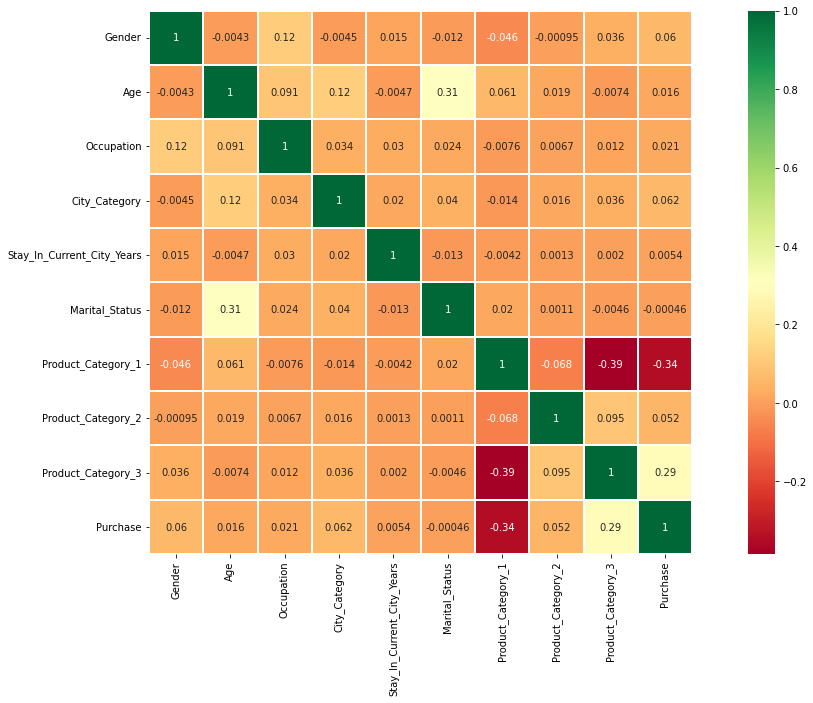

In [40]:
plt.figure(figsize = (20, 10))
sns.heatmap(train.corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap="RdYlGn", linecolor='white', annot=True)

In [41]:
# Standardizing the features and creating features and target for the model in the next step
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Get the features and target
features = train.drop("Purchase", axis = 1)
target = train["Purchase"]

# Scale the features
X = scaler.fit_transform(features)

## Divide the Data into Batches

In [53]:
# Due to constraints on the RAM, divind the data into batches can help conserve memory
import torch
from torch import nn

# Convert numpy array into torch tensors
X = torch.from_numpy(features.to_numpy()).type(torch.float)
y = torch.from_numpy(target.to_numpy()).type(torch.float)

# Split the features and target into train and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.20, shuffle = True, random_state = 42)

from torch.utils.data import DataLoader, TensorDataset
import os

# Turn the data into TensorDataset
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# Divide the data into batches
BATCH_SIZE = 1000

train_dataloader = DataLoader(dataset = train_dataset,
                              batch_size = BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle = True)

val_dataloader = DataLoader(dataset = val_dataset,
                            batch_size = BATCH_SIZE,
                            num_workers = os.cpu_count())

## Creating a Model and Setting up Loss/Optimizer

In [43]:
# Setup device agnostc code
device = "cuda" if torch.cuda.is_available() else "cpu"

In [44]:
# Create the model
class BlackFridayModelV0(nn.Module):
  def __init__(self, in_features : int, hidden_units : int, out_features : int):
    super().__init__()
    self.linear_layer = nn.Sequential(
        nn.Linear(in_features = in_features, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = out_features)
    )

  def forward(self, x : torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

In [121]:
in_features = X.shape[1]
out_features = 1

# Initializing the Model
model_0 = BlackFridayModelV0(in_features, 10, out_features)

In [122]:
# Loss Function
loss_fn = nn.MSELoss().to(device)

# Optimizer
optimizer = torch.optim.Adam(params = model_0.parameters(), lr = 0.01)

## Setting up Training and Validation Functions

In [97]:
def train_step(model : nn.Module,
               train_dataloader : torch.utils.data.DataLoader,
               loss_fn : nn.Module,
               optimizer : torch.optim,
               device : torch.device = device):
  
  model.train()
  train_loss = 0
  for batch, (X, y) in enumerate(train_dataloader):

    # Set the data to the correct device 
    X, y = X.to(device), y.to(device)

    # Forward Pass
    y_pred = model(X)

    # Calculate the loss
    loss = loss_fn(y_pred.squeeze(), y)
    train_loss += loss

    # Optimizer zero grad
    optimizer.zero_grad()

    # Backpropagation
    loss.backward()

    # Optimizer step
    optimizer.step()

  train_loss /= len(train_dataloader)

  return train_loss

In [98]:
def validation_step(model : nn.Module,
               val_dataloader : torch.utils.data.DataLoader,
               loss_fn : nn.Module,
               device : torch.device = device):
  
  model.eval()
  val_loss = 0
  with torch.inference_mode():
    for (X, y) in val_dataloader:

      # Set the data to the correct device
      X, y = X.to(device), y.to(device)

      # Forward Propagation
      val_pred = model(X)

      # Calculate the loss
      loss = loss_fn(val_pred.squeeze(), y)
      val_loss += loss

  return val_loss

## Training the Model

In [99]:
from tqdm.auto import tqdm
from timeit import default_timer as timer

start_time = timer()

def train_loop(model : nn.Module,
               train_dataloader : torch.utils.data.DataLoader,
               val_dataloader : torch.utils.data.DataLoader,
               loss_fn : nn.Module,
               optimizer: torch.optim,
               num_epochs : int = 20,
               device : torch.device = device):
  
  # Set the model to the correct device
  model.to(device)
  model_results = {
      "train_loss" : [],
      "validation_loss" : [],
      "training_time" : 0 
  }

  for epoch in tqdm(range(num_epochs)):
    train_loss = train_step(model = model,
                            train_dataloader = train_dataloader,
                            loss_fn = loss_fn,
                            optimizer = optimizer,
                            device = device)
    validation_loss = validation_step(model = model,
                            val_dataloader = val_dataloader,
                            loss_fn = loss_fn,
                            device = device)
    
    if epoch % 4 == 0:
      print(f"Train Loss: {train_loss} | Validation Loss: {validation_loss}")
    
    model_results["train_loss"].append(train_loss)
    model_results["validation_loss"].append(validation_loss)
  
  end_time = timer()
  total_train_time = end_time - start_time
  model_results["training_time"] = total_train_time
  print(f"Total training time was {total_train_time} seconds")

  return model_results

In [123]:
NUM_EPOCHS = 100
model_0_results = train_loop(model = model_0,
                             train_dataloader = train_dataloader,
                             val_dataloader = val_dataloader,
                             loss_fn = loss_fn,
                             optimizer = optimizer,
                             num_epochs = NUM_EPOCHS,
                             device = device)

  0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 45844108.0 | Validation Loss: 3056618752.0
Train Loss: 18115434.0 | Validation Loss: 1971762304.0
Train Loss: 17756896.0 | Validation Loss: 1945273472.0
Train Loss: 17718344.0 | Validation Loss: 1947245184.0
Train Loss: 17723554.0 | Validation Loss: 1945068160.0
Train Loss: 17715738.0 | Validation Loss: 1948486272.0
Train Loss: 17717396.0 | Validation Loss: 1943324544.0
Train Loss: 17711660.0 | Validation Loss: 1943325824.0
Train Loss: 17716106.0 | Validation Loss: 1944302464.0
Train Loss: 17710686.0 | Validation Loss: 1943812864.0
Train Loss: 17713872.0 | Validation Loss: 1948841856.0
Train Loss: 17717014.0 | Validation Loss: 1945538816.0
Train Loss: 17712562.0 | Validation Loss: 1941902336.0
Train Loss: 17712728.0 | Validation Loss: 1941947776.0
Train Loss: 17717018.0 | Validation Loss: 1941736320.0
Train Loss: 17709942.0 | Validation Loss: 1942536704.0
Train Loss: 17700656.0 | Validation Loss: 1942594304.0
Train Loss: 17695990.0 | Validation Loss: 1942085248.0
Train Loss

In [119]:
def plot_results(model_results):
  num_epochs = range(len(model_results["train_loss"]))
  plt.plot(num_epochs, torch.tensor(model_results["train_loss"]).cpu(), label = "Training Loss")
  plt.plot(num_epochs, torch.tensor(model_results["validation_loss"]).cpu(), label = "Validation Loss")
  plt.title("Loss Curve")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()

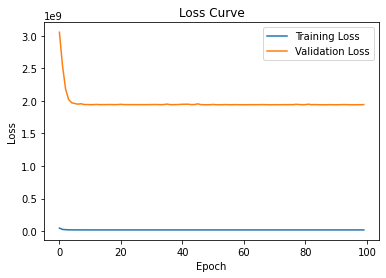

In [124]:
plot_results(model_0_results)